Import necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Load the Data

In [2]:
# Load Scala benchmark data
scala_idle_data = pd.read_csv('../data/20250307090345_thread_ring_akka_actor_benchmark_idle_power.csv')
scala_bench_data = pd.read_csv('../data/20250307090356_thread_ring_akka_actor_benchmark_power_metrics.csv')

# Load Erlang benchmark data
erlang_idle_data = pd.read_csv('../data/20250307090440_thread_ring_benchmark_idle_power.csv')
erlang_bench_data = pd.read_csv('../data/20250307090451_thread_ring_benchmark_power_metrics.csv')

Preview the Data

In [3]:
print("Scala Idle Data Sample:")
print(scala_idle_data.shape)
scala_idle_data.head()

Scala Idle Data Sample:
(5, 9)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level
0,(Fri Mar 7 09:03:46 2025 +0100) (1008.53ms ela...,4.940,0.08130,0.914,7.43,0.95,57.48,61.16 C,Nominal
1,(Fri Mar 7 09:03:47 2025 +0100) (1007.39ms ela...,1.450,0.09430,0.847,3.80,0.62,36.92,60.69 C,Nominal
2,(Fri Mar 7 09:03:48 2025 +0100) (1008.51ms ela...,1.110,0.02410,0.609,3.09,0.31,22.80,60.25 C,Nominal
3,(Fri Mar 7 09:03:49 2025 +0100) (1007.41ms ela...,0.868,0.00000,0.661,2.86,0.46,25.01,60.11 C,Nominal
4,(Fri Mar 7 09:03:50 2025 +0100) (1005.97ms ela...,2.690,0.00182,0.610,4.64,0.40,25.62,59.95 C,Nominal


In [ ]:
print("Scala Benchmark Data Sample:")
print(scala_bench_data.shape)
scala_bench_data.head()

In [ ]:
print("Erlang Idle Data Sample:")
print(erlang_idle_data.shape)
erlang_idle_data.head()

In [ ]:
print("Erlang Benchmark Data Sample:")
print(erlang_bench_data.shape)
erlang_bench_data.head()

Cleaning the Data


In [ ]:
# Function to clean timestamp and elapsed time
def clean_data(df):
    df_copy = df.copy()  # Ensure we don't modify the original data

    # Convert Timestamp to datetime format (extract date-time pattern)
    df_copy['Timestamp'] = pd.to_datetime(
        df['Timestamp'].str.extract(r'(\w{3} \w{3} \d{1,2} \d{2}:\d{2}:\d{2} \d{4})')[0], 
        errors='coerce'
    )

    # Extract elapsed time in milliseconds
    df_copy['Time Elapsed (ms)'] = pd.to_numeric(
        df['Timestamp'].str.extract(r'\((\d+\.\d+)ms elapsed\)')[0], 
        errors='coerce'
    )
    
    # Extract numeric temperature values
    df_copy['CPU Temp(C)'] = df['CPU Temp(C)'].str.extract(r'(\d+\.\d+|\d+)').astype(float)

    return df_copy

In [7]:
scala_idle_data_clean = clean_data(scala_idle_data)
scala_bench_data_clean = clean_data(scala_bench_data)
erlang_idle_data_clean = clean_data(erlang_idle_data)
erlang_bench_data_clean = clean_data(erlang_bench_data)

Verify Cleaned Data

In [8]:
print("Scala Idle Cleaned Data Sample:")
print(scala_idle_data_clean.shape)
scala_idle_data_clean.head()


Scala Idle Cleaned Data Sample:
(5, 10)


,Timestamp,CPU Core Power(W),GT Power(W),DRAM Power(W),(CPUs+GT+SA) Power(W),Avg Num Cores Active,Cores Active(%),CPU Temp(C),Pressure Level,Time Elapsed (ms)
0,2025-03-07 09:03:46,4.940,0.08130,0.914,7.43,0.95,57.48,61.16,Nominal,1008.53
1,2025-03-07 09:03:47,1.450,0.09430,0.847,3.80,0.62,36.92,60.69,Nominal,1007.39
2,2025-03-07 09:03:48,1.110,0.02410,0.609,3.09,0.31,22.80,60.25,Nominal,1008.51
3,2025-03-07 09:03:49,0.868,0.00000,0.661,2.86,0.46,25.01,60.11,Nominal,1007.41
4,2025-03-07 09:03:50,2.690,0.00182,0.610,4.64,0.40,25.62,59.95,Nominal,1005.97


In [ ]:
print("Scala Benchmark Cleaned Data Sample:")
print(scala_bench_data_clean.shape)
scala_bench_data_clean.head()


In [ ]:
print("Erlang Idle Cleaned Data Sample:")
print(erlang_idle_data_clean.shape)
erlang_idle_data_clean.head()


In [ ]:
print("Erlang Benchmark Cleaned Data Sample:")
print(erlang_bench_data_clean.shape)
erlang_bench_data_clean.head()

Handling Outliers


In [9]:
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
def remove_outliers(df, columns):
    """
    Removes outliers from the specified columns using the IQR method.
    """
    df_clean = df.copy()
    
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    
    return df_clean

In [11]:
# Remove outliers from power data
# scala_idle_data_clean = remove_outliers(scala_idle_data_clean, "CPU Core Power(W)")
# scala_bench_data_clean = remove_outliers(scala_bench_data_clean, "CPU Core Power(W)")
# erlang_idle_data_clean = remove_outliers(erlang_idle_data_clean, "CPU Core Power(W)")
# erlang_bench_data_clean = remove_outliers(erlang_bench_data_clean, "CPU Core Power(W)")

columns_of_interest = [
    "CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", 
    "(CPUs+GT+SA) Power(W)", "Avg Num Cores Active", "CPU Temp(C)"
]

scala_idle_data_clean = remove_outliers(scala_idle_data_clean, columns_of_interest)
scala_bench_data_clean = remove_outliers(scala_bench_data_clean, columns_of_interest)
erlang_idle_data_clean = remove_outliers(erlang_idle_data_clean, columns_of_interest)
erlang_bench_data_clean = remove_outliers(erlang_bench_data_clean, columns_of_interest)

In [12]:
print("Scala Idle Cleaned Data Shape: ",scala_idle_data_clean.shape)
print("Scala Benchmark Cleaned Data Shape: ", scala_bench_data_clean.shape)
print("Erlang Idle Cleaned Data Shape: ", scala_idle_data_clean.shape)
print("Erlang Benchmark Cleaned Data Shape: ", scala_bench_data_clean.shape)

Scala Idle Cleaned Data Shape:  (4, 10)
Scala Benchmark Cleaned Data Shape:  (8, 10)
Erlang Idle Cleaned Data Shape:  (4, 10)
Erlang Benchmark Cleaned Data Shape:  (8, 10)


Visualization

In [13]:
# plt.figure(figsize=(12, 6))

# plt.plot(scala_idle_data_clean["Timestamp"], scala_idle_data_clean["CPU Core Power(W)"], label="Scala Idle", marker='o', linestyle='-')
# plt.plot(scala_bench_data_clean["Timestamp"], scala_bench_data_clean["CPU Core Power(W)"], label="Scala Benchmark", marker='o', linestyle='-')
# plt.plot(erlang_idle_data_clean["Timestamp"], erlang_idle_data_clean["CPU Core Power(W)"], label="Erlang Idle", marker='s', linestyle='--')
# plt.plot(erlang_bench_data_clean["Timestamp"], erlang_bench_data_clean["CPU Core Power(W)"], label="Erlang Benchmark", marker='s', linestyle='--')

# plt.xlabel("Timestamp")
# plt.ylabel("CPU Core Power (W)")
# plt.title("CPU Core Power Consumption Comparison")
# plt.legend()
# plt.xticks(rotation=45)
# plt.grid()
# plt.show()

def plot_graphs(idle_df, bench_df, title):
    """
    Plots graphs for power usage in idle vs. benchmark states.
    """
    columns_to_plot = [
        "CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", 
        "(CPUs+GT+SA) Power(W)", "Avg Num Cores Active", "CPU Temp(C)"
    ]
    
    plt.figure(figsize=(12, 8))
    
    for column in columns_to_plot:
        plt.plot(idle_df["Timestamp"], idle_df[column], label=f"Idle - {column}", linestyle='dashed')
        plt.plot(bench_df["Timestamp"], bench_df[column], label=f"Benchmark - {column}")

    plt.xlabel("Time")
    plt.ylabel("Power / Temperature / Activity")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

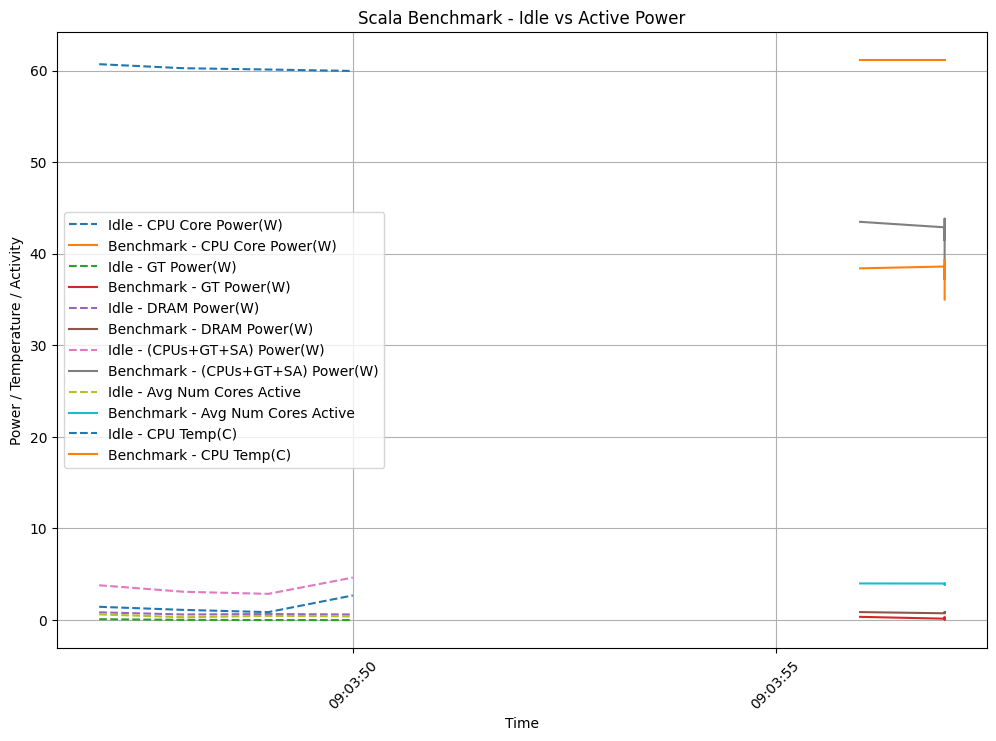

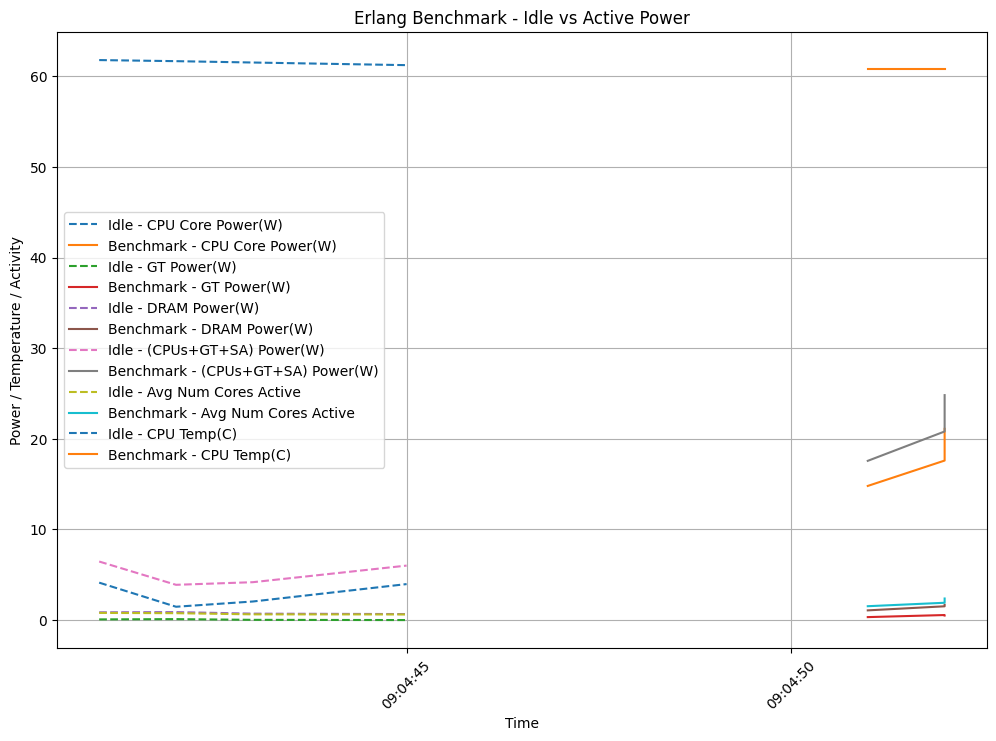

In [14]:
plot_graphs(scala_idle_data_clean, scala_bench_data_clean, "Scala Benchmark - Idle vs Active Power")
plot_graphs(erlang_idle_data_clean, erlang_bench_data_clean, "Erlang Benchmark - Idle vs Active Power")

Compute Ernegy Consumption

In [15]:
def calculate_net_energy(bench_df, idle_df, time_column, power_columns):
    """
    Calculates the net energy consumption by subtracting idle power from benchmark power.
    """
    avg_idle_power = idle_df[power_columns].mean()  # Compute average idle power per column
    time_elapsed = bench_df[time_column].diff().fillna(0) / 1000  # Convert ms to seconds

    net_energy = {}
    for column in power_columns:
        energy = ((bench_df[column] - avg_idle_power[column]) * time_elapsed).sum()
        net_energy[column] = energy

    return net_energy

In [16]:
power_columns = ["CPU Core Power(W)", "GT Power(W)", "DRAM Power(W)", "(CPUs+GT+SA) Power(W)"]

scala_energy = calculate_net_energy(scala_bench_data_clean, scala_idle_data_clean, "Time Elapsed (ms)", power_columns)
erlang_energy = calculate_net_energy(erlang_bench_data_clean, erlang_idle_data_clean, "Time Elapsed (ms)", power_columns)

# Compute energy difference
energy_difference = {key: scala_energy[key] - erlang_energy[key] for key in scala_energy}

In [17]:
print("\nNet Energy Consumption (Joules) Comparison:")
print("Scala Benchmark:", scala_energy)
print("Erlang Benchmark:", erlang_energy)
print("Energy Difference (Scala - Erlang):", energy_difference)


Net Energy Consumption (Joules) Comparison:
Scala Benchmark: {'CPU Core Power(W)': np.float64(-0.016213365000000014), 'GT Power(W)': np.float64(-0.00024005085000000138), 'DRAM Power(W)': np.float64(-1.6012500000001182e-05), '(CPUs+GT+SA) Power(W)': np.float64(-0.017979125000000006)}
Erlang Benchmark: {'CPU Core Power(W)': np.float64(-0.060327950000000075), 'GT Power(W)': np.float64(-0.001861323873750001), 'DRAM Power(W)': np.float64(-0.003029230000000003), '(CPUs+GT+SA) Power(W)': np.float64(-0.06469415000000008)}
Energy Difference (Scala - Erlang): {'CPU Core Power(W)': np.float64(0.04411458500000006), 'GT Power(W)': np.float64(0.0016212730237499997), 'DRAM Power(W)': np.float64(0.003013217500000002), '(CPUs+GT+SA) Power(W)': np.float64(0.04671502500000007)}
